# Predicting Income Groups Using World Development Indicators
-----

 <a id='Executive'></a>
 ## Executive Summary

In order to optimize our machine learning models, there were many things to take into account.  First we must deal with NaN values.  Imputing the mean of each income group and feature, as opposed to just each feature, helps to prevent outliers and noise within our dataset.  The dataset has features, such as GNI and GDP, which directly affects the income group a country falls into.  We are looking to predict the economic standing of countries using world development so we dropped features that pertained to GNI and GDP.  Feature selection is an important process to reduce training time and defend against overfitting. In selecting features, we used an anova based univariate method and also a tree based method.  We were able to obtain a combination of 37, 25, 17 and 8 features to use when training our models.

In training and testing our models, we created a pipeline that would simulate every feature and hyperparameter combination using a 5 fold cross validation method in order to give us the best method that we would test on unseen data and re-tune according to performance.  Our models performed extremely well in predicting high income groups and really well in predicting low income groups.  The models started to dip in accuracy, precision and recall as they attempted to predict upper and lower middle income groups.  The model that performed the best was the random forest model, using only 17 features to predict income groups.  This model had an accuracy, precision, recall and f1-score of just under 94%.  What really set the model apart from all other models was its ability to be exremely precise in predicting low income groups, predicting 177 out of 178 correctly.

<a id='Table of Contents'>

#### <a href='#Model'>Model Selection, Tuning and Training</a>


-----
## Table of Contents


#### <a href='#Executive'>Executive Summary</a>

----
#### <a href='#Import'>Import Tools, Read in and Separate Data, Define Functions</a>


- <a href='#Functions'>Defining Functions</a>

----
#### <a href='#Fill'>Fill Missing Data</a>

#### <a href='#Predictors'>Give Predictors Nominal Classes</a>

#### <a href='#Drop'>Drop GNI & GDP Columns</a>

- <a href='#GNI'>GNI per capita Distribution</a>

#### <a href='#Split'>Split and Normalize Train and Test Sets</a>

#### <a href='#Feature'>Feature Selection</a>

- <a href='#Feature2'>Feature Combinations</a>

#### <a href='#Model'>Model Selection, Tuning and Training</a>

- <a href='#rf'>Random Forest</a>

- <a href='#lr'>Logistic Regression</a>

- <a href='#svc'>Support Vector Machines</a>

- <a href='#knn'>k-Nearest Neighbors</a>

- <a href='#gb'>Gradient Boosting</a>

#### <a href='#Compare'>Model Comparison</a>

- <a href='#Bar'>Closer Look</a>

- <a href='#Spider'>Deeper Look</a>

#### <a href='#Compare2'>Compare Predictions with Various Feature Selection</a>

- <a href='#rf2'>Random Forest</a>

- <a href='#lr2'>Logistic Regression</a>

- <a href='#svc2'>Support Vector Machines</a>

- <a href='#knn2'>k-Nearest Neighbors</a>

- <a href='#gb2'>Gradient Boosting</a>

#### <a href='#Conclusion'>Conclusion</a>

#### <a href='#Future'>Future Work</a>

<a id='Import'></a>
## Import Necessary Packages & Data
<a href='#Table of Contents'>Table of Contents</a>

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from math import pi
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

import warnings
warnings.filterwarnings('ignore')

First we'll read in the data from the World Banks world development indicator dataset.  The income groups are read in separately so that we may deal with missing values as they pertain to each income group to prevent filling values with what would become outliers for each income group as a whole.  Doing so will reduce prediction error.

In [2]:
# Read in data

# WDI with NaN values
wdi_nan = pd.read_csv('WDI_csv/wrangled/wdi_pivot.csv')

# WDI income groups, used to fill nan values
high = pd.read_csv('WDI_csv/eda/high.csv')
um = pd.read_csv('WDI_csv/eda/upper_middle.csv')
lm = pd.read_csv('WDI_csv/eda/lower_middle.csv')
low = pd.read_csv('WDI_csv/eda/low.csv')
corr = pd.read_csv('WDI_csv/eda/wdi_corr.csv')

# Get rid of 'unnamed: 0' columns
wdi_nan = wdi_nan.iloc[:,1:]
high = high.iloc[:,2:]
um = um.iloc[:,2:]
lm = lm.iloc[:,2:]
low = low.iloc[:,2:]
corr = corr.iloc[:,1:]

income_groups = [high, um, lm, low]

<a id='Functions'></a>
## Define Functions for Model Training

The functions below will provide easier readability as we go through the notebook.  The functions used are:
- plot_confusion_matrix
    - compute and plot confusion matrix
- select_model
    - fit, predict, score model, save score, plot confusion matrix
- select_models
    - fit, predict, score variations of the same model
- spider_plot
    - visualize accuracy, f-1, recall and precision scores of each model
    
<a href='#Table of Contents'>Table of Contents</a>

In [3]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,
                         subplot=0):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = wdi_ml.ig.unique()
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # And label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax



def select_model(features, model):
    '''This function trains and predicts a multiclass classification model and displays its score'''
    
    # Fit model
    clf = model.fit(Xn_train[features], y_train)
    
    # Make predictions
    y_predict = clf.predict(Xn_test[features])
    
    # Score model
    print('Accuracy: {}'.format(accuracy_score(y_test, y_predict)))
    print(classification_report(y_test, y_predict))
    
    # Create dataframe of scored model
    global dataframe
    dataframe = pd.DataFrame(classification_report(y_test, y_predict, output_dict=True)).transpose()
    
    # Plot non-normalized confusion matrix
    plot_confusion_matrix(y_test, y_predict, classes=wdi_ml.ig,
                          title='Confusion matrix, without normalization')
    
    # Plot normalized confusion matrix
    plot_confusion_matrix(y_test, y_predict, classes=wdi_ml.ig, normalize=True,
                          title='Normalized confusion matrix')

    
def select_models(features, model):
    '''This function trains and predicts a multiclass classification model with various 
    types of features and displays its score'''

    # Fit model
    clf = model.fit(Xn_train[features], y_train)
    
    # Make predictions
    y_predict = clf.predict(Xn_test[features])
    
    # Score model
    print('Accuracy: {}'.format(accuracy_score(y_test, y_predict)))
    
    
def spider_plot():
    '''This plots the comparison between models of their various 
    scores averaged as a while and between each income group'''
    # ------- PART 1: Create background
         
    # number of variable
    categories=list(average)
    N = len(categories)
         
    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
         
    # Parameters for for loop
    params = [list((np.linspace(0.955,0.985,3))), list((np.linspace(0.84,0.928,3))), 
              list((np.linspace(0.9,0.93,3))), list((np.linspace(0.92,0.995,3)))]
    begs = [0.955, 0.84, 0.85, 0.92]
    ends = [0.99, 0.93, 0.928, 0.995]
    labels = ['f1-score', 'precision', 'recall']
    ii = [221,222,223,224]
    
    plt.figure(figsize=(10,10))
    ax = plt.subplot(111, polar=True)
     
    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
     
    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories)
     
    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks(list(np.linspace(0.9,0.942,3)), color="grey", size=7)
    plt.ylim(0.9,0.942)
     
     
    # ------- PART 2: Add plots
     
    # Plot each individual = each line of the data
     
    # Ind1
    values=average.loc['f1-score'].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label="f1-score")
    ax.fill(angles, values, 'b', alpha=0.1)
     
    # Ind2
    values=average.loc['precision'].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label="precision")
    ax.fill(angles, values, 'r', alpha=0.1)
    
    # Ind3
    values=average.loc['recall'].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label="recall")
    ax.fill(angles, values, 'y', alpha=0.1)
    
    # Ind4
    values=average.loc['accuracy'].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label="accuracy")
    ax.fill(angles, values, 'y', alpha=0.1)
    
    
    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.show()
    
    plt.figure(figsize=(10,10))
    
    # number of variable
    categories=list(high_score)
    N = len(categories)
         
    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    # Plot subplots
    for score, param, i, beg, end in zip(scores, params, ii, begs, ends):
        
        # Initialise the spider plot
        ax = plt.subplot(i, polar=True)
         
        # If you want the first axis to be on top:
        ax.set_theta_offset(pi / 2)
        ax.set_theta_direction(-1)
         
        # Draw one axe per variable + add labels labels yet
        plt.xticks(angles[:-1], categories)
         
        # Draw ylabels
        ax.set_rlabel_position(0)
        plt.yticks(param, color="grey", size=7)
        plt.ylim(beg, end)
         
         
        # ------- PART 2: Add plots
         
        # Plot each individual = each line of the data
         
        # Ind1
        values=score.loc['f1-score'].values.flatten().tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=1, linestyle='solid', label="f1-score")
        ax.fill(angles, values, 'b', alpha=0.1)
         
        # Ind2
        values=score.loc['precision'].values.flatten().tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=1, linestyle='solid', label="precision")
        ax.fill(angles, values, 'r', alpha=0.1)
        
        # Ind3
        values=score.loc['recall'].values.flatten().tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=1, linestyle='solid', label="recall")
        ax.fill(angles, values, 'y', alpha=0.1)
        
        
        # Add legend
        plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.tight_layout()
    plt.show()

<a id='Fill'></a>
## Fill Missing Data

Percent of missing data: 0.08448640307081814
Number of rows and columns: (2424, 345)


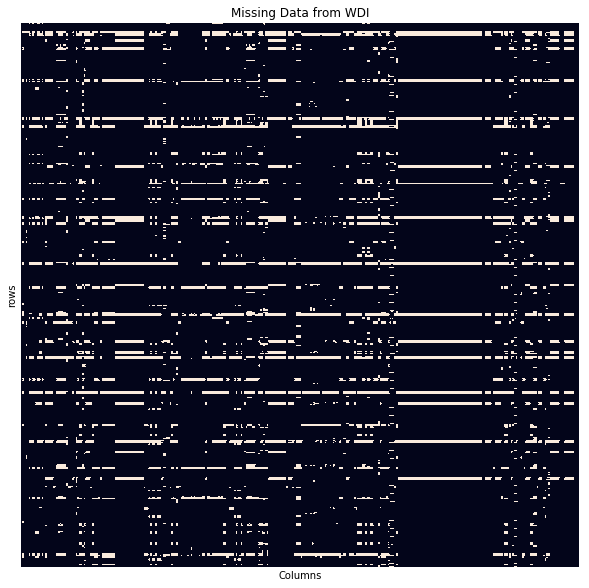

In [4]:
# Percent of total NaN values
print('Percent of missing data: {}'.
      format(wdi_nan.isnull().sum().sum()/wdi_nan.count().sum()))
print('Number of rows and columns: {}'.format(wdi_nan.shape))

# Plot Visual of Nan Values
plt.subplots(figsize=(10,10))
sns.heatmap(wdi_nan.isnull(), cbar=False)
plt.title('Missing Data from WDI')
plt.xticks([])
plt.xlabel('Columns')
plt.yticks([])
plt.ylabel('rows')
plt.show()

As a whole, the dataset has just over 8.4% NaN values.  In order to train our models we need to fill the values with like values, making sure to keep from adding outlier values.

As we break the dataset into features or columns, NaN values are pretty random, but do seem to have some correlation with development and record keeping practices of a country.  There are 345 features and just about every feature has NaN values with an average of roughly 7% to 8% NaN values per feature.  Very few features have over %15 NaN values and less than 55 of the 345 features have 10% or more NaN values.  Most features fall between 8% and 10% NaN values and there are several features that have 7% or less NaN values.

In order to deal with the missing values, we will impute the average of each feature as it relates to the row's or country's income group.  Countries that are high income will have the average high income value of the feature, countries that are low income will have the average low income value of the feature, and so forth.

<a href='#Table of Contents'>Table of Contents</a>

345


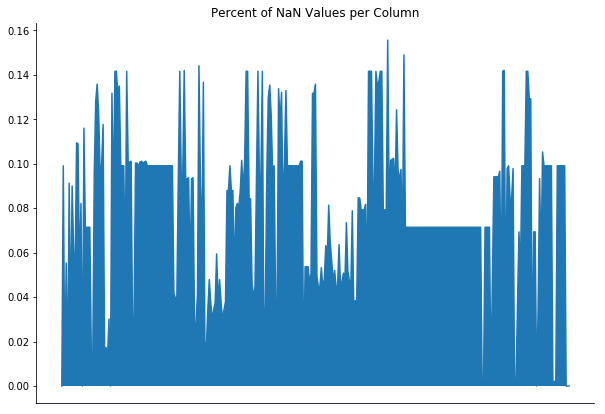

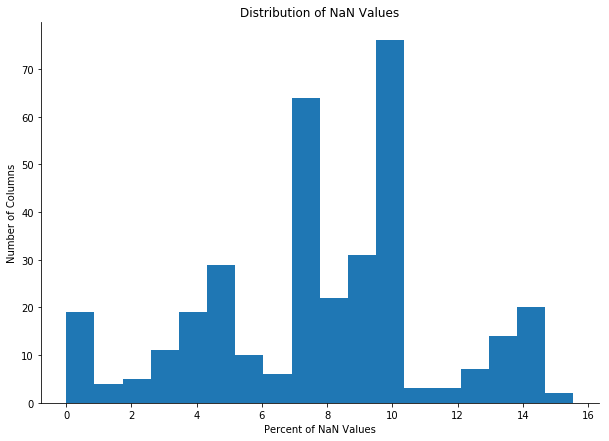

In [5]:
print(len(wdi_nan.columns))

# Plot Nan Values
plt.figure(figsize=(10,7))
plt.plot(wdi_nan.columns, wdi_nan.isnull().sum()/len(wdi_nan*100))
plt.title('Percent of NaN Values per Column')
plt.fill_between(wdi_nan.columns, wdi_nan.isnull().sum()/len(wdi_nan*100))
plt.xticks([])
sns.despine(right=True, top=True)
plt.show()

# Plot Distribution of Nan Values
plt.figure(figsize=(10,7))
plt.hist(wdi_nan.isnull().sum()/len(wdi_nan)*100, bins=int(np.sqrt(len(wdi_nan.columns))))
plt.title('Distribution of NaN Values')
plt.ylabel('Number of Columns')
plt.xlabel('Percent of NaN Values')
sns.despine(right=True, top=True)
plt.show()

In [6]:
# Impute mean of each income group
imp = SimpleImputer(missing_values=np.nan, strategy='mean')

# Create arrays of imputed data
hi = imp.fit_transform(high.iloc[:,1:-2])
umi = imp.fit_transform(um.iloc[:,1:-2])
lmi = imp.fit_transform(lm.iloc[:,1:-2])
li = imp.fit_transform(low.iloc[:,1:-2])

# Combine all the imputed arrays
imputed = [hi, umi, lmi, li]
df = np.concatenate(imputed)

# Combine income groups into dataframe in the same order as imputed arrays
wdi = pd.concat([high, um, lm, low])

# Replace all numerical values in dataframe with imputed arrays
wdi.iloc[:, 1:-2] = df

# Display before and after imputation
print(wdi_nan.isnull().sum().head())
print(wdi.isnull().sum().head())
# Percent of total NaN values
print('\npercent of missing data: {}'.format(wdi.isnull().sum().sum()/wdi.count().sum()))

country                                                                   0
Access to clean fuels and technologies for cooking (% of population)    240
Access to electricity (% of population)                                  14
Access to electricity, rural (% of rural population)                    134
Access to electricity, urban (% of urban population)                     14
dtype: int64
country                                                                 0
Access to clean fuels and technologies for cooking (% of population)    0
Access to electricity (% of population)                                 0
Access to electricity, rural (% of rural population)                    0
Access to electricity, urban (% of urban population)                    0
dtype: int64

percent of missing data: 0.0


In [7]:
# Sort dataframe into original order
wdi = wdi.sort_values(['country','year'])

# View imputed dataframe
pd.concat([wdi.head(2),wdi_nan.head(2)])

,country,Access to clean fuels and technologies for cooking (% of population),Access to electricity (% of population),"Access to electricity, rural (% of rural population)","Access to electricity, urban (% of urban population)",Adjusted savings: carbon dioxide damage (% of GNI),Adjusted savings: carbon dioxide damage (current US$),Adjusted savings: consumption of fixed capital (% of GNI),Adjusted savings: consumption of fixed capital (current US$),Adjusted savings: education expenditure (% of GNI),...,Urban population growth (annual %),"Vulnerable employment, female (% of female employment) (modeled ILO estimate)","Vulnerable employment, male (% of male employment) (modeled ILO estimate)","Vulnerable employment, total (% of total employment) (modeled ILO estimate)","Wage and salaried workers, female (% of female employment) (modeled ILO estimate)","Wage and salaried workers, male (% of male employment) (modeled ILO estimate)","Wage and salaried workers, total (% of total employment) (modeled ILO estimate)",year,region,income_group
0,Afghanistan,13.49,23.000000,13.000000,74.000000,1.062383,2.495481e+07,9.786023,5.806829e+08,2.604448,...,4.768647,96.667002,88.143999,90.952999,3.22,11.183,8.559,2005.0,South Asia,Low income
1,Afghanistan,14.81,28.228613,12.543863,80.042892,1.062383,3.298676e+07,9.786023,6.874334e+08,2.648119,...,4.123188,96.626999,88.017996,90.847000,3.26,11.312,8.666,2006.0,South Asia,Low income
0,Afghanistan,13.49,23.000000,13.000000,74.000000,NaN,2.495481e+07,NaN,5.806829e+08,2.604448,...,4.768647,96.667002,88.143999,90.952999,3.22,11.183,8.559,2005.0,South Asia,Low income
1,Afghanistan,14.81,28.228613,12.543863,80.042892,NaN,3.298676e+07,NaN,6.874334e+08,2.648119,...,4.123188,96.626999,88.017996,90.847000,3.26,11.312,8.666,2006.0,South Asia,Low income


<a id='Predictors'></a>
## Give Predictors Nominal Classes, Drop Countries and Regions
Before we can start testing models, we have to convert our target feature into a float or integer.  We will assign each income group to a number and use those numbers as its representatives.
- High Income = 0
- Upper Middle Income = 1
- Lower Middle Income = 2
- Low Income = 3

There are a reasonable amount of countries in each income group so the need for a multilabel train test split is not needed in order to make sure all groups are represented.

We are also going to drop countries and regions because we are focused on the relationship between income group and world development and not the area of the world a country is in.

<a href='#Table of Contents'>Table of Contents</a>

In [8]:
# Create new column with the exact income group labels
wdi['ig'] = wdi['income_group']

# Assign income group labels to a number
wdi['ig'][wdi['ig'] == 'High income'] = 0
wdi['ig'][wdi['ig'] == 'Upper middle income'] = 1
wdi['ig'][wdi['ig'] == 'Lower middle income'] = 2
wdi['ig'][wdi['ig'] == 'Low income'] = 3

print(wdi.income_group.value_counts())
print(wdi.ig.value_counts())

High income            787
Lower middle income    613
Upper middle income    555
Low income             469
Name: income_group, dtype: int64
0    787
2    613
1    555
3    469
Name: ig, dtype: int64


In [9]:
# Drop countries, regions and income group labels (keep nominal labels)
wdi_ml_all = pd.concat([wdi.iloc[:,1:-3], wdi.iloc[:,-1]], axis=1)
# Convert to integers
wdi_ml_all.ig = wdi_ml_all.ig.astype('int')
target_name = wdi.iloc[:,-2:-1]

# Confirm
wdi_ml_all.head(2)

,Access to clean fuels and technologies for cooking (% of population),Access to electricity (% of population),"Access to electricity, rural (% of rural population)","Access to electricity, urban (% of urban population)",Adjusted savings: carbon dioxide damage (% of GNI),Adjusted savings: carbon dioxide damage (current US$),Adjusted savings: consumption of fixed capital (% of GNI),Adjusted savings: consumption of fixed capital (current US$),Adjusted savings: education expenditure (% of GNI),Adjusted savings: education expenditure (current US$),...,Urban population (% of total),Urban population growth (annual %),"Vulnerable employment, female (% of female employment) (modeled ILO estimate)","Vulnerable employment, male (% of male employment) (modeled ILO estimate)","Vulnerable employment, total (% of total employment) (modeled ILO estimate)","Wage and salaried workers, female (% of female employment) (modeled ILO estimate)","Wage and salaried workers, male (% of male employment) (modeled ILO estimate)","Wage and salaried workers, total (% of total employment) (modeled ILO estimate)",year,ig
0,13.49,23.000000,13.000000,74.000000,1.062383,2.495481e+07,9.786023,5.806829e+08,2.604448,5.628162e+08,...,22.703,4.768647,96.667002,88.143999,90.952999,3.22,11.183,8.559,2005.0,3
1,14.81,28.228613,12.543863,80.042892,1.062383,3.298676e+07,9.786023,6.874334e+08,2.648119,5.628162e+08,...,22.907,4.123188,96.626999,88.017996,90.847000,3.26,11.312,8.666,2006.0,3


<a id='Drop'></a>
## Drop Columns Directly Related to Income Categories
<a href='#Table of Contents'>Table of Contents</a>

[]

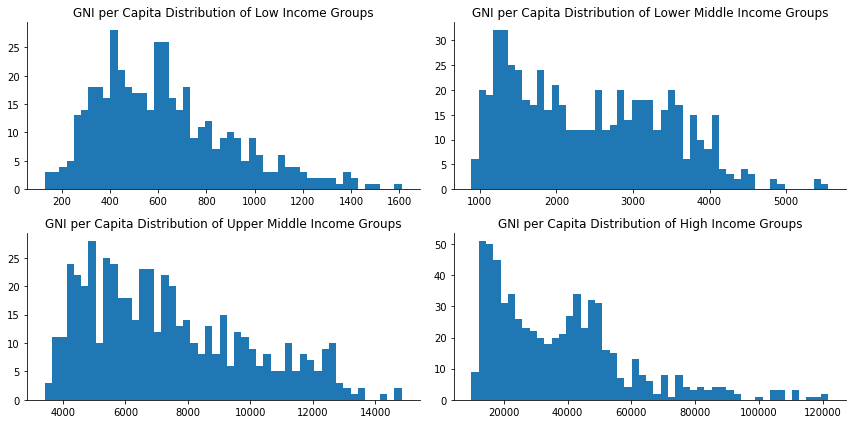

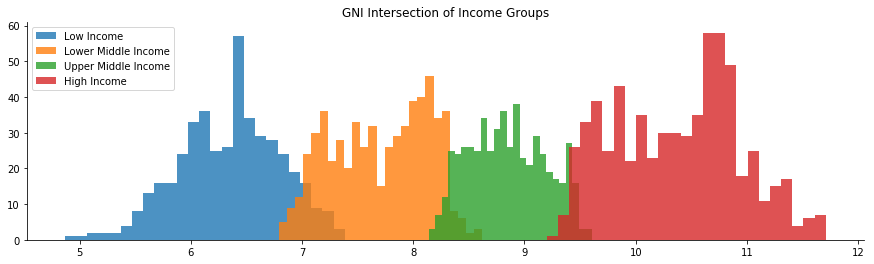

In [10]:
dists = [low, lm, um, high]
plots = [1,2,3,4,]
titles = ['Low Income', 'Lower Middle Income', 'Upper Middle Income', 'High Income']

# Plot distribution of GNI per capita of income groups
plt.figure(figsize=(12,6))
for plot, dist, title in zip(plots, dists, titles):
    plt.subplot(2,2,plot)
    dist['GNI per capita, Atlas method (current US$)'].hist(bins=int(np.sqrt(len(wdi))))
    plt.title('GNI per Capita Distribution of {} Groups'.format(title))
    sns.despine(right=True, top=True)
    plt.grid(False)
    plt.tight_layout()
    
# Plot intersecting distributions
plt.figure(figsize=(15,4))
for dist, title in zip(dists, titles):
    np.log(dist['GNI per capita, Atlas method (current US$)']).hist(bins=25, alpha=0.8, label=title)
plt.legend(loc='upper left')
sns.despine(right=True, top=True)
plt.grid(False)
plt.title('GNI Intersection of Income Groups')
plt.plot()

<a id='GNI'></a>
As stated in the exploratory data analysis, GNI per capita is directly related to the income group that a country belongs to.  The histograms above show a positive skew in the relationship between income group and GNI per capita.  As we look closer into each income group, the bulk of countries within income groups are in the lower end of the GNI threshold showing a large separation of GNI per capita between the majority of countries within income groups, with high income countries having a wide range in GNI per capita.  

There are some outliers that have higher GNI per capita than others in neighboring income groups, showing it is not the only feature in determining income grouping.  We can see this by taking the natural log of GNI per capita of each country and viewing the interection of distributions, which has become more normally distributed.

While GNI per capita is not the only factor in determining income groupings, it is a major one.  All of the features that have to do with the economic outlook of a country, GDP, GNI, GDP PPP per capita, GNI per capita, etc. will directly affect its income grouping.  Because we are looking at how world development can help predict economic success manifested via the income group a country belongs to, we will drop all of the columns relating to direct economic success of a country.

Of course this will make our predictions a little more difficult to be accurate because countries, such as China, which is the second largest economy but has been in the lower middle and upper middle income categories, has disparities in living standards throughout the country.  For example, under 60% of the population have access to clean fuels and technologies for cooking, but over 97% have access to electricity.  Access to basic drinking water has risen from 84% to 96% but using basic sanitation services has ranged from 65% to 84%.

<a href='#Table of Contents'>Table of Contents</a>

In [11]:
# Gather all GNI and GDP columns directly relate to Income Group
gni = list(wdi.columns[wdi.columns.str.contains('GNI')])[5:]
gdp = list(wdi.columns[wdi.columns.str.contains('GDP')])[8:26]

# Combine into one list
gni.extend(gdp)
gni

['GNI (current LCU)',
 'GNI (current US$)',
 'GNI per capita (current LCU)',
 'GNI per capita, Atlas method (current US$)',
 'GNI per capita, PPP (current international $)',
 'GNI, Atlas method (current US$)',
 'GNI, PPP (current international $)',
 'GDP (constant 2010 US$)',
 'GDP (constant LCU)',
 'GDP (current LCU)',
 'GDP (current US$)',
 'GDP deflator (base year varies by country)',
 'GDP deflator: linked series (base year varies by country)',
 'GDP growth (annual %)',
 'GDP per capita (constant 2010 US$)',
 'GDP per capita (constant LCU)',
 'GDP per capita (current LCU)',
 'GDP per capita (current US$)',
 'GDP per capita growth (annual %)',
 'GDP per capita, PPP (constant 2011 international $)',
 'GDP per capita, PPP (current international $)',
 'GDP per person employed (constant 2011 PPP $)',
 'GDP, PPP (constant 2011 international $)',
 'GDP, PPP (current international $)',
 'GDP: linked series (current LCU)']

In [12]:
# Drop columns
wdi_ml = wdi_ml_all.drop(gni, axis=1)

<a id='Split'></a>
## Split Data and Normalize Train and Test Sets

We want to split our data into two, independent variables and target variable (prediction).  We also want to split the data into training and testing sets.  The testing set will remain unused until the parameters are tuned and features selected so that our models can work on unseen data.  The goal is to prevent data leakage into the test set.

Data is also on several different scales such as population, percentage, growth.  Numbers can range from less than 1 to millions.  Because of this we will normalize or scale our data by subtracting each value by the mean of the column and dividing by the standard deviation. 

<a href='#Table of Contents'>Table of Contents</a>

In [13]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    wdi_ml.iloc[:,:-1], wdi_ml.iloc[:,-1], test_size=0.3, random_state=10)


# Normalize training data
scaler = StandardScaler().fit(X_train)

Xn_train = pd.DataFrame(scaler.transform(X_train), columns = X_train.columns)

# Normalize testing data by using mean and SD of training set
Xn_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

<a id='Feature'></a>
## Feature Selection

Feature selection is important in reducing training time and defends against overfitting which increases generalizability.  It is important to select features that have the most affect on our target without having them be too dependent on each other.  Dependence among features will get in the way of our prediction accuracy.

In selecting features, we will use [scikit learn's](https://scikit-learn.org/stable/modules/feature_selection.html) guide to feature selection.  We will use univariate feature selection which selects the best features on univariate statistical tests, in this case anova.  And we will use tree based feature selection which uses the same method as a random forest to find the best features.  After we determine our features, we will take the top 25, 10 and 5 from each and drop duplicates.  In training our models we will use all features, features from each method and combinations of the two methods to see what gives us the best model.

<a href='#Table of Contents'>Table of Contents</a>

Current health expenditure per capita (current US$)                                  0.065571
Employment in agriculture (% of total employment) (modeled ILO estimate)             0.039286
Population ages 0-14 (% of total)                                                    0.037108
Vulnerable employment, female (% of female employment) (modeled ILO estimate)        0.034685
Wage and salaried workers, female (% of female employment) (modeled ILO estimate)    0.031817
Population ages 5-9, female (% of female population)                                 0.028665
Individuals using the Internet (% of population)                                     0.027487
Agriculture, forestry, and fishing, value added (% of GDP)                           0.020393
Population ages 65 and above (% of total)                                            0.019770
Contributing family workers, total (% of total employment) (modeled ILO estimate)    0.019668
People using at least basic sanitation services (% of popula

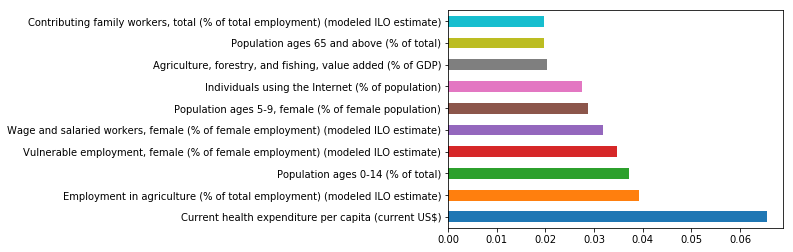

In [14]:
# Tree based
X = Xn_train # Independent columns
y = y_train   # Target column

# Instantiate model
model = ExtraTreesClassifier(random_state=10)
model.fit(X,y)

# Plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
print(feat_importances.sort_values(ascending=False).head(20))
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

Vulnerable employment, female (% of female employment) (modeled ILO estimate)        2038.150086
Vulnerable employment, total (% of total employment) (modeled ILO estimate)          2014.566371
Wage and salaried workers, female (% of female employment) (modeled ILO estimate)    1974.988770
Self-employed, female (% of female employment) (modeled ILO estimate)                1974.988652
Wage and salaried workers, total (% of total employment) (modeled ILO estimate)      1944.937167
Self-employed, total (% of total employment) (modeled ILO estimate)                  1944.936885
Employment in agriculture, male (% of male employment) (modeled ILO estimate)        1873.853434
Employment in agriculture (% of total employment) (modeled ILO estimate)             1861.056622
Vulnerable employment, male (% of male employment) (modeled ILO estimate)            1792.045514
Access to clean fuels and technologies for cooking (% of population)                 1686.587220
Wage and salaried workers, mal

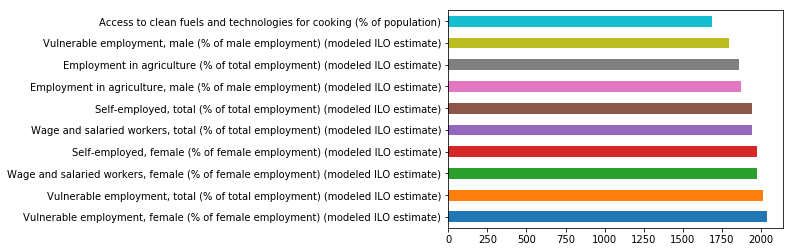

In [15]:
# Univariate 
X = Xn_train  # Independent columns
y = y_train    # Target column

# Apply SelectKBest class to extract top 25 best features
# f_classif uses Anova testing
bestfeatures = SelectKBest(score_func=f_classif, k=25)
fit = bestfeatures.fit(X,y)

featureScores = pd.Series(fit.scores_, index=X.columns)

print(featureScores.nlargest(20))  # Print 10 best features
featureScores.sort_values(ascending=False).head(10).plot(kind='barh')
plt.show()

<a id='Feature2'></a>

In [16]:
# Create lists for features
both = []
all_features = []
top_20 = []
top_10 = []
univariate = []
tree_based = []
    
# Place features into both list
for item in list(featureScores.sort_values(ascending=False).head(25).index):
    if item in list(feat_importances.nlargest(25).index):
        both.append(item)

# Place features into all list
for item in list(featureScores.sort_values(ascending=False).head(25).index):
    all_features.append(item)
for item in list(feat_importances.nlargest(25).index):
    all_features.append(item)
    
# Place features into top 20 list
for item in list(featureScores.sort_values(ascending=False).head(10).index):
    top_20.append(item)
for item in list(feat_importances.nlargest(10).index):
    top_20.append(item)
    
# Place features into top 10 list
for item in list(featureScores.sort_values(ascending=False).head(5).index):
    top_10.append(item)
for item in list(feat_importances.nlargest(5).index):
    top_10.append(item)
    
# Place features into univariate list
for item in list(featureScores.sort_values(ascending=False).head(20).index):
    univariate.append(item)
    
# Place features into treebased list
for item in list(feat_importances.nlargest(20).index):
    tree_based.append(item)
    
# Drop duplicates in all features list
all_features = list(pd.DataFrame(all_features).drop_duplicates()[0])

# Drop duplicates from top 20
top_17 = list(pd.DataFrame(top_20).drop_duplicates()[0])

# Drop duplicates from top 10
top_8 = list(pd.DataFrame(top_10).drop_duplicates()[0])

# All features
default = list(Xn_train.columns)

# Create list of features and names for parameter tuning
features = [default, all_features, both, top_17, top_8, univariate, tree_based]
names = ['Default Features', '37 Features from Selection Methods', 'Features in Both Selection Methods', 
         'Top 17 Features', 'Top 8 Features', 'Univariate Feature Selection', 'Tree-Based Feature Selection']
     
print('default features:', len(default))
print('features in specifically in both selection methods: {}\nall features selected in both methods: {}'
      .format(len(both), len(all_features)))
print('features in top 20: {}\nfeatures in top 10: {}'
      .format(len(top_17), len(top_8)))

default features: 317
features in specifically in both selection methods: 13
all features selected in both methods: 37
features in top 20: 17
features in top 10: 8


<a id='Feature2'></a>
## Feature Combinations

The univariate selection method appears to have selected too many correlating features while the tree based method does not.  We have tested taking out all features that had correlation between them and our models performed extremely poorly.  While it is not suggested to have correlated features, it does not always hurt if their correlation to the target variable outweighs the negatives.  Above, are the 20 features selected from each method as well as the code for how we combined our features.  Below is the list of top 8, top 17 and 13 features that occurred in both selection methods.

During  modeling we will be using all 317 features, 20 tree based features, 20 univariate features, 13 features selected in both methods, 37 features that make up the top 25 of each method (top 50 minus duplicates), top 17 of both selection methods (top 20 minus duplicates) and top 8 (top 10 minus duplicates).

<a href='#Table of Contents'>Table of Contents</a>

In [17]:
list(top_17)

['Vulnerable employment, female (% of female employment) (modeled ILO estimate)',
 'Vulnerable employment, total (% of total employment) (modeled ILO estimate)',
 'Wage and salaried workers, female (% of female employment) (modeled ILO estimate)',
 'Self-employed, female (% of female employment) (modeled ILO estimate)',
 'Wage and salaried workers, total (% of total employment) (modeled ILO estimate)',
 'Self-employed, total (% of total employment) (modeled ILO estimate)',
 'Employment in agriculture, male (% of male employment) (modeled ILO estimate)',
 'Employment in agriculture (% of total employment) (modeled ILO estimate)',
 'Vulnerable employment, male (% of male employment) (modeled ILO estimate)',
 'Access to clean fuels and technologies for cooking (% of population)',
 'Current health expenditure per capita (current US$)',
 'Population ages 0-14 (% of total)',
 'Population ages 5-9, female (% of female population)',
 'Individuals using the Internet (% of population)',
 'Agricu

In [18]:
list(top_8)

['Vulnerable employment, female (% of female employment) (modeled ILO estimate)',
 'Vulnerable employment, total (% of total employment) (modeled ILO estimate)',
 'Wage and salaried workers, female (% of female employment) (modeled ILO estimate)',
 'Self-employed, female (% of female employment) (modeled ILO estimate)',
 'Wage and salaried workers, total (% of total employment) (modeled ILO estimate)',
 'Current health expenditure per capita (current US$)',
 'Employment in agriculture (% of total employment) (modeled ILO estimate)',
 'Population ages 0-14 (% of total)']

In [19]:
list(both)

['Vulnerable employment, female (% of female employment) (modeled ILO estimate)',
 'Wage and salaried workers, female (% of female employment) (modeled ILO estimate)',
 'Self-employed, female (% of female employment) (modeled ILO estimate)',
 'Wage and salaried workers, total (% of total employment) (modeled ILO estimate)',
 'Self-employed, total (% of total employment) (modeled ILO estimate)',
 'Employment in agriculture (% of total employment) (modeled ILO estimate)',
 'Access to clean fuels and technologies for cooking (% of population)',
 'Individuals using the Internet (% of population)',
 'Agriculture, forestry, and fishing, value added (% of GDP)',
 'Employment in agriculture, female (% of female employment) (modeled ILO estimate)',
 'People using at least basic sanitation services (% of population)',
 'Access to electricity (% of population)',
 'Population ages 0-14 (% of total)']

<a id='Model'></a>
## Model Selection, Tuning & Training

To find the best set of features and models we will create a pipeline and loop through our features.  The pipeline will allow us to check what hyperparameters give the best testing accuracy through 5 fold cross validation for each feature and select which feature is best to use for each training model.  Lastly, we will test our best features and hyperparameters on the unseen data for each model and we will either stick with what gridsearchCV gives us or use the manually tuned set of features and hyperparametrs that we find gives us a higher accuracy score.

Accuracy is not the only thing we are concerned about.  We want to see how our models are placing our observations in the respective income groups.  There are 4 ways in which our model makes predictions.

    - True positive: the actual class of the data point was 1(True) and the predicted is also 1(True)
    - True negative: the actual class of the data point was 0(False) and the predicted is also 0(False)
    - False positive: the actual class of the data point was 0(False) and the predicted is 1(True). False is because the model has predicted incorrectly and positive because the class predicted was a positive one. (1)
    - False negative: the actual class of the data point was 1(True) and the predicted is 0(False). False is because the model has predicted incorrectly and negative because the class predicted was a negative one. (0)
    
1. Accuracy is the number of correct predictions (TP + TN) / (TP + FP + FN + TN) 
    - correctness
2. Precision is the number of picking correctly vs. picking incorrectly (TP) / (TP + FP)
    - diagnosed with cancer and having it, diagnosed with cancer and not having it
3. Recall is the number in the class that we actually classified to be in that class (TP) / (TP + FN)
    - diagnosed with cancer and having it, not diagnosed with cancer and having it
4. F-1 is a combination of precision and recall


In training our models will be using Random Forest, Logistic Regression, Support Vector Machines, K-Nearest Neighbor and Gradient Boosting.  When we train our models with 5 fold cross validation, it gives us a good idea of how it will perform with its hyperparameters and features.  The model is taking the average of each fold and has seen previous data.  Again, we are preventing data leakage into the test data.  Because of this, our test data may and will give us different results.  So we will determine if our gridsearchCV came up with the best features and hyperparameters or if our manual process does.

<a href='#Table of Contents'>Table of Contents</a>

<a id='rf'></a>
### Random Forest

**gridsearchCV determination:**
- best features: tree-based
- max depth: none
- max features: sqrt
- n_estimators: 100
- best score: 0.9522405660377359

**actual score:** 0.9354395604395604

**our findings:**
- best features: top 17
- max depth: none
- max features: sqrt
- n_estimators: 75
- best score: 0.9395604395604396

<a href='#Table of Contents'>Table of Contents</a>

<a href='#Model'>Model Selection, Tuning and Training</a>

In [20]:
# Create pipeline
pipeline = make_pipeline(RandomForestClassifier(random_state=10))

# Select hyperparameters
hyperparameters = {'randomforestclassifier__max_features': ['sqrt', 'log2', None],
                  'randomforestclassifier__max_depth': [None, 5, 3, 1],
                  'randomforestclassifier__n_estimators': [10, 25, 50, 75, 100]}

# For loop to select best set of features, hyperparameters
best_score = 0
best_feature = str()
best_param = str()
# Loop
for feature, name in zip(features, names): # Go into feature
    clf = GridSearchCV(pipeline, hyperparameters, cv=5) # Check hyperparameters
    clf.fit(Xn_train[feature], y_train)
    if clf.best_score_ > best_score: # If better than others, save
        best_score = clf.best_score_
        best_feature = name
        best_param = clf.best_params_
        
print('best feature:', best_feature)
print('best parameters: ', best_param)
print('best score: ', best_score)

best feature: Tree-Based Feature Selection
best parameters:  {'randomforestclassifier__max_depth': None, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 100}
best score:  0.9522405660377359


Accuracy: 0.9395604395604396
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       222
           1       0.89      0.89      0.89       177
           2       0.91      0.92      0.92       192
           3       0.99      0.96      0.98       137

   micro avg       0.94      0.94      0.94       728
   macro avg       0.94      0.94      0.94       728
weighted avg       0.94      0.94      0.94       728



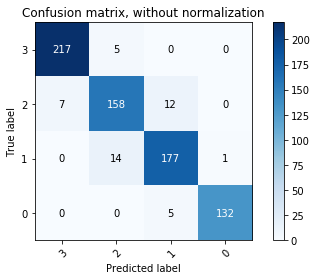

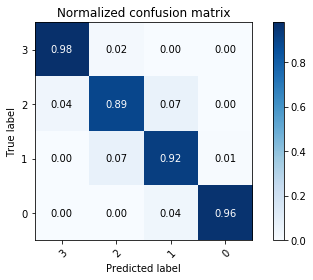

In [21]:
# Test model
select_model(top_17, RandomForestClassifier(random_state=10, 
                            n_estimators=75, 
                            max_features='sqrt', 
                            max_depth=None))
# Rename dataframe
random_forest = dataframe

<a id='lr'></a>
### Logistic Regression

**gridsearchCV determination:**
- best features: default (all 317)
- C: 100
- solver: newton-cg
- best score: 0.9398584905660378

**actual score:** 0.9271978021978022

**our findings:**
- best features: all features in both selection methods (37)
- C: 100
- solver: newton-cg
- best score: 0.9065934065934066 (2nd best, but much less features)

<a href='#Table of Contents'>Table of Contents</a>

<a href='#Model'>Model Selection, Tuning and Training</a>

In [22]:
# Create pipeline
pipeline = make_pipeline(LogisticRegression(random_state=10))

# Select hyperparameters
hyperparameters = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100],
                  'logisticregression__solver': ['lbfgs', 'sag', 'saga', 'newton-cg']}

# For loop to select best set of features, hyperparameters
best_score = 0
best_feature = str()
best_param = str()
# Loop
for feature, name in zip(features, names): # Go into feature
    clf = GridSearchCV(pipeline, hyperparameters, cv=5) # Check hyperparameters
    clf.fit(Xn_train[feature], y_train)
    if clf.best_score_ > best_score: # If better than others, save
        best_score = clf.best_score_
        best_feature = name
        best_param = clf.best_params_
        
print('best feature:', best_feature)
print('best parameters: ', best_param)
print('best score: ', best_score)

best feature: Default Features
best parameters:  {'logisticregression__C': 100, 'logisticregression__solver': 'newton-cg'}
best score:  0.9398584905660378


Accuracy: 0.9065934065934066
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       222
           1       0.87      0.85      0.86       177
           2       0.85      0.85      0.85       192
           3       0.92      0.95      0.93       137

   micro avg       0.91      0.91      0.91       728
   macro avg       0.90      0.91      0.90       728
weighted avg       0.91      0.91      0.91       728



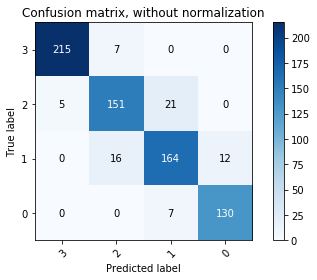

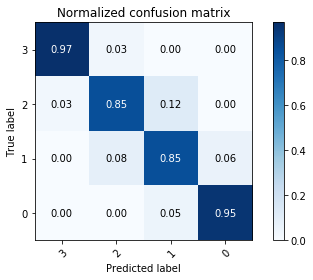

In [23]:
# Test model
select_model(all_features, LogisticRegression(random_state=10, 
                         solver='newton-cg', 
                         multi_class='multinomial', 
                         C=10))
# Rename dataframe
log_reg = dataframe

<a id='svc'></a>
### Support Vector Machines

**gridsearchCV determination:**
- best features: top 17
- C: 100
- gamma: 1
- kernel: 'rbf'
- best score: 0.9516509433962265

**actual score:** 0.91758241758241752

**our findings:**
- best features: all features in both selection methods (37)
- C: 100
- gamma: 1
- kernel: 'rbf'
- best score: 0.9313186813186813
    - top 8: 0.92582
    
<a href='#Table of Contents'>Table of Contents</a>

<a href='#Model'>Model Selection, Tuning and Training</a>

In [24]:
# Create pipeline
pipeline = make_pipeline(SVC(random_state=10))

# Select hyperparameters
hyperparameters = {'svc__C': [0.001, 0.01, 0.1, 1, 10, 100],
                  'svc__kernel': ['rbf', 'linear'],
                  'svc__gamma': [0.001, 0.01, 0.1, 1]}

# For loop to select best set of features, hyperparameters
best_score = 0
best_feature = str()
best_param = str()
# Loop
for feature, name in zip(features, names): # Go into feature
    clf = GridSearchCV(pipeline, hyperparameters, cv=5) # Check hyperparameters
    clf.fit(Xn_train[feature], y_train)
    if clf.best_score_ > best_score: # If better than others, save
        best_score = clf.best_score_
        best_feature = name
        best_param = clf.best_params_
        
print('best feature:', best_feature)
print('best parameters: ', best_param)
print('best score: ', best_score)

best feature: Top 17 Features
best parameters:  {'svc__C': 100, 'svc__gamma': 1, 'svc__kernel': 'rbf'}
best score:  0.9516509433962265


Accuracy: 0.9313186813186813
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       222
           1       0.90      0.92      0.91       177
           2       0.90      0.89      0.89       192
           3       0.94      0.93      0.94       137

   micro avg       0.93      0.93      0.93       728
   macro avg       0.93      0.93      0.93       728
weighted avg       0.93      0.93      0.93       728



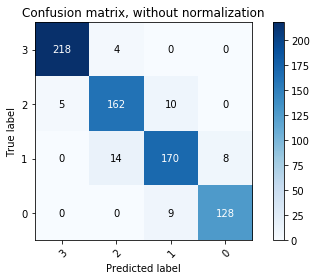

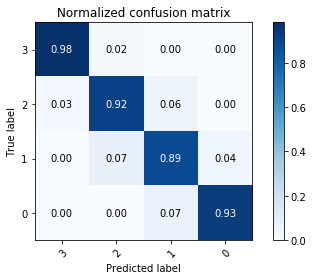

In [25]:
# Test model
select_model(all_features, SVC(random_state=10, 
          C=100, 
          kernel='rbf', 
          gamma=1))
# Rename dataframe
svc = dataframe

<a id='knn'></a>
### K-Nearest Neighbors

**gridsearchCV determination:**
- best features: all features in both selection methods (37)
- n_neighbors: 1
- best score: 0.9528301886792453

**actual score:** 0.9271978021978022

**our findings:**
- best features: tree-based
- n_neighbors: 1
- best score: 0.9271978021978022
    - same score but less features required
    
<a href='#Table of Contents'>Table of Contents</a>

<a href='#Model'>Model Selection, Tuning and Training</a>

In [26]:
# Create pipeline
pipeline = make_pipeline(KNeighborsClassifier())

# Select hyperparameters
hyperparameters = {'kneighborsclassifier__n_neighbors': np.arange(1,10)}

# For loop to select best set of features, hyperparameters
best_score = 0
best_feature = str()
best_param = str()
# Loop
for feature, name in zip(features, names): # Go into feature
    clf = GridSearchCV(pipeline, hyperparameters, cv=5) # Check hyperparameters
    clf.fit(Xn_train[feature], y_train)
    if clf.best_score_ > best_score: # If better than others, save
        best_score = clf.best_score_
        best_feature = name
        best_param = clf.best_params_
        
print('best feature:', best_feature)
print('best parameters: ', best_param)
print('best score: ', best_score)

best feature: 37 Features from Selection Methods
best parameters:  {'kneighborsclassifier__n_neighbors': 1}
best score:  0.9528301886792453


Accuracy: 0.9271978021978022
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       222
           1       0.90      0.90      0.90       177
           2       0.89      0.88      0.89       192
           3       0.93      0.93      0.93       137

   micro avg       0.93      0.93      0.93       728
   macro avg       0.93      0.92      0.92       728
weighted avg       0.93      0.93      0.93       728



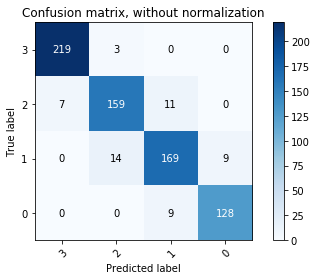

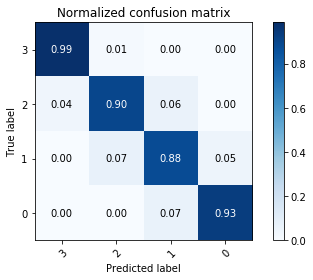

In [27]:
# Test model
select_model(tree_based, KNeighborsClassifier(n_neighbors=1))

# Rename dataframe
knn = dataframe

<a id='gb'></a>
### Gradient Boost

**gridsearchCV determination:**
- best features: default
- max_features: log2
- best score: 0.9492924528301887

**actual score:** 0.9409340659340659
        - CPU times: user 2 µs, sys: 0 ns, total: 2 µs
        - Wall time: 3.81 µs
        *default performed faster in this case*

**our findings:**
- best features: top-17
- max_features:sqrt
- best score: 0.9368131868131868 (2nd best but much less features)
        - CPU times: user 1 µs, sys: 1 µs, total: 2 µs
        - Wall time: 4.05 µs
        
<a href='#Table of Contents'>Table of Contents</a>

<a href='#Model'>Model Selection, Tuning and Training</a>

In [28]:
# Create pipeline
pipeline = make_pipeline(GradientBoostingClassifier(random_state=10))

# Select hyperparameters
hyperparameters = {'gradientboostingclassifier__max_features': ['sqrt', 'log2']}

# For loop to select best set of features, hyperparameters
best_score = 0
best_feature = str()
best_param = str()
# Loop
for feature, name in zip(features, names): # Go into feature
    clf = GridSearchCV(pipeline, hyperparameters, cv=5) # Check hyperparameters
    clf.fit(Xn_train[feature], y_train)
    if clf.best_score_ > best_score: # If better than others, save
        best_score = clf.best_score_
        best_feature = name
        best_param = clf.best_params_
        
print('best feature:', best_feature)
print('best parameters: ', best_param)
print('best score: ', best_score)

best feature: Default Features
best parameters:  {'gradientboostingclassifier__max_features': 'log2'}
best score:  0.9492924528301887


Accuracy: 0.9368131868131868
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       222
           1       0.90      0.92      0.91       177
           2       0.92      0.91      0.92       192
           3       0.96      0.95      0.95       137

   micro avg       0.94      0.94      0.94       728
   macro avg       0.94      0.94      0.94       728
weighted avg       0.94      0.94      0.94       728



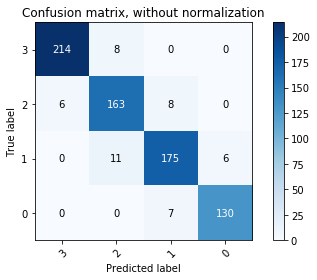

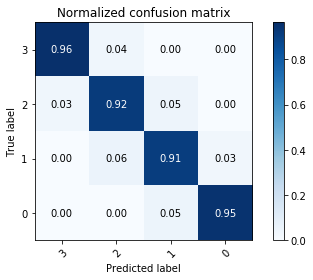

In [29]:
# Test model
select_model(top_17, GradientBoostingClassifier(random_state=10, 
                            n_estimators=50, 
                            max_features='sqrt', 
                            max_depth=None))
# Rename dataframe
gradient_boost = dataframe

<a id='Compare'></a>
## Compare Models

As we look at the confusion matrices, all of the models perform much better in predicting high income and low income countries, but dip in precision and recall when predicting upper middle and lower middle income countries.  This is likely due to the nuances that separate the groups and the fact that the middle categories have to be differentiated in 2 directions as opposed to 1 like the outer categories.  Again this can be seen from the distribution of income groups as they relate to GNI per capita

<a href='#Table of Contents'>Table of Contents</a>

[]

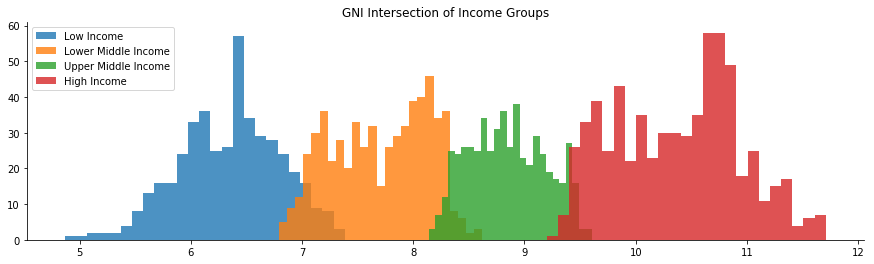

In [30]:
# Plot intersecting distributions
plt.figure(figsize=(15,4))
for dist, title in zip(dists, titles):
    np.log(dist['GNI per capita, Atlas method (current US$)']).hist(bins=25, alpha=0.8, label=title)
plt.legend(loc='upper left')
sns.despine(right=True, top=True)
plt.grid(False)
plt.title('GNI Intersection of Income Groups')
plt.plot()

We are now going to evaluate and compare the performances of each model.  We're going to look at how each model performed as a whole and how each model performed in predicting each income group.

In [31]:
# Dataframes created and renamed after each model have testing scores

# Create dataframe
average = pd.DataFrame()

# Combine the mean of each testing score of each model
average[['random_forest', 
         'log_reg', 
         'svc', 
         'knn', 
         'gradient_boost']] = pd.concat(
                                [random_forest.iloc[:4,:3].mean(), 
                                log_reg.iloc[:5,:3].mean(), 
                                svc.iloc[:4,:3].mean(), 
                                knn.iloc[:4,:3].mean(), 
                                gradient_boost.iloc[:4,:3].mean()], 
                                axis=1)

# Add accuracy score to average score
accuracy = {'random_forest': random_forest.iloc[-3,:3].mean(), 
            'log_reg': log_reg.iloc[-3,:3].mean(), 
            'svc': svc.iloc[-3,:3].mean(), 
            'knn': knn.iloc[-3,:3].mean(),  
            'gradient_boost': gradient_boost.iloc[-3,:3].mean()}

accuracy = pd.Series(accuracy).rename('accuracy')
average = average.append(accuracy)

# Create empty dataframes and put into list
high_score = pd.DataFrame()
um_score = pd.DataFrame()
lm_score = pd.DataFrame()
low_score = pd.DataFrame()
scores = [high_score, um_score, lm_score, low_score]


# Obtain testing scores for each model according to income group
for i, score in enumerate(scores):
    score = pd.concat(
                [random_forest.iloc[i,:3], 
                log_reg.iloc[i,:3], 
                svc.iloc[i,:3], 
                knn.iloc[i,:3], 
                gradient_boost.iloc[i,:3]], 
                axis=1)
    
    score.columns = ['random_forest', 
                     'log_reg', 
                     'svc', 
                     'knn', 
                     'gradient_boost']
    # Assign to list of dataframes
    scores[i] = score

# Assign dataframes to scores
high_score = scores[0]
um_score = scores[1]
lm_score = scores[2]
low_score = scores[3]

<a id='Bar'></a>
<a href='#Table of Contents'>Table of Contents</a>

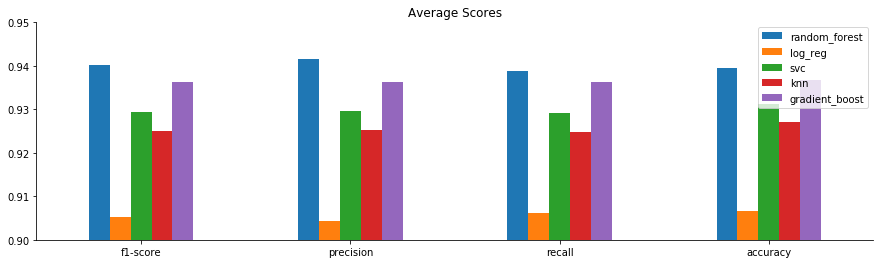

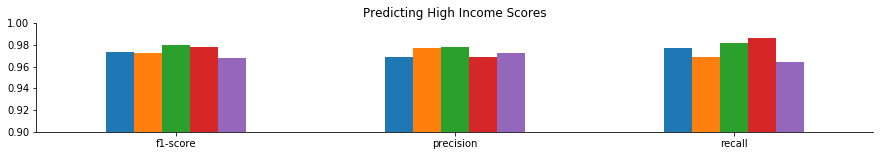

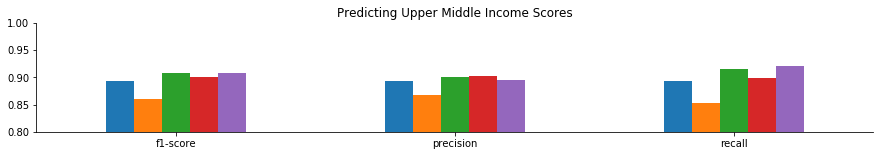

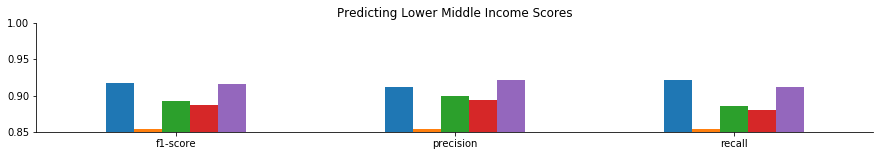

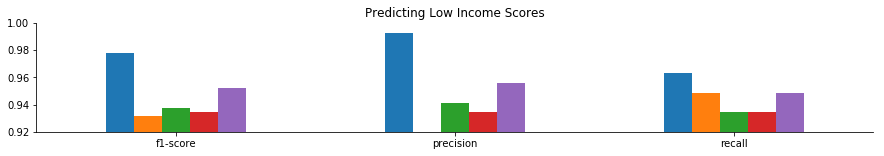

In [32]:
# Plot average scores and accuracy
average.plot(kind='bar', figsize=(15,4))
plt.legend(loc='upper right')
plt.ylim(0.9,0.95)
plt.title('Average Scores')
plt.xticks(rotation=0)
sns.despine(right=True, top=True)
plt.show()

# Plot scores in predicting each income group
limits = [0.9, 0.8, 0.85, 0.92]
names=['Predicting High Income Scores', 
       'Predicting Upper Middle Income Scores', 
       'Predicting Lower Middle Income Scores', 
       'Predicting Low Income Scores']
for score, limit, name in zip(scores, limits, names):
    score.plot(kind='bar', figsize=(15,2), legend=None)
    plt.ylim(limit,1)
    plt.title(name)
    plt.xticks(rotation=0)
    sns.despine(right=True, top=True)
    plt.show()

As it pertains to looking at each model as a whole, random forest outperforms every model in f1-score, precision, recall and accuracy. It's followed closely by gradient boosting, then svc, and k-nearest neighbors.  Logistic regression is the worst performer across the bored just barely hovering over 90% in each measured field.

All of the models perform well in predicting high income countries with an f-1 score, precision score and recall score all over 95%.  As we go deeper into the categories, we start to see dips in each scoring method, especially with the gradient boosting (gradual), k-nearest neighbors (gradual), svc (gradual) and logistic regression (extreme) models.  Random forest dips, then rises as we approach predicting low income groups.

We can see that svc is the best model in predicting high income and upper middle income countries, but does not do nearly as well with lower middle income and low income countries.

<a id='Spider'></a>
<a href='#Table of Contents'>Table of Contents</a>

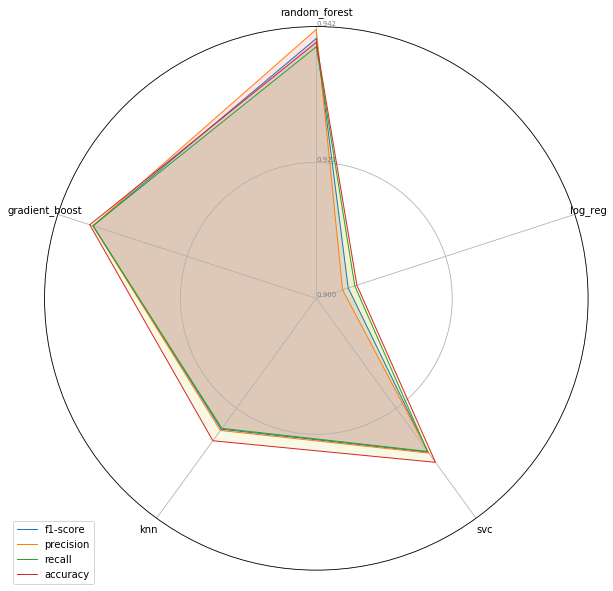

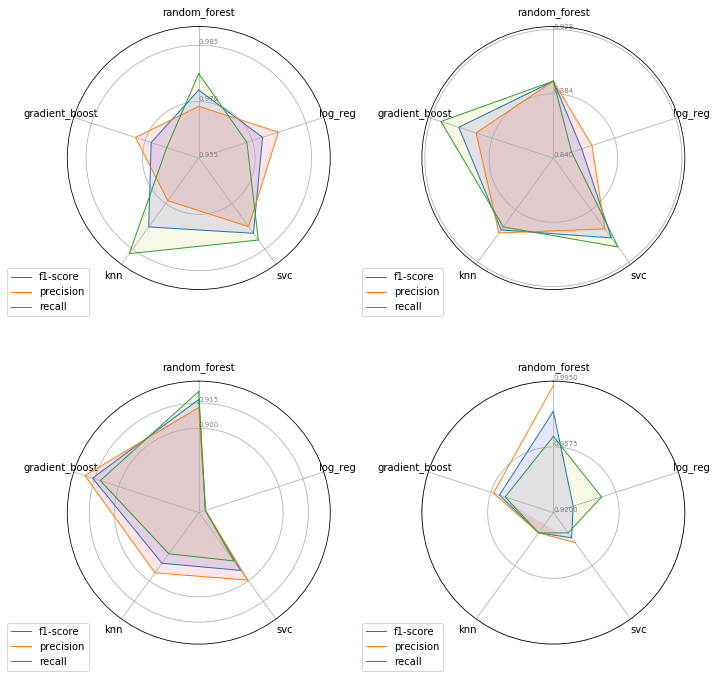

In [33]:
spider_plot()

As we zoom into the differences in performance of each model we can see the strengths and weakness each model has in certain aspects of predicting each income group.  Random forest, again as a whole, outperforms all other models, followed by gradient boosting, svc, k-nearest neighbors and logistic regression.

When we examine each models performance predicting each income group we can easily observe the following:

**High Income Group:**
- knn has the best recall, but sacrifices precision
- svc has the best balance of recall and precision, followed by random forest

**Upper Middle Income Group:**
- svc  has the best optimization of recall and precision, followed by gradient boosting
- random forest and knn are balanced but not optimized in their predictions

**Lower Middle Income Group:**
- logistic regression has fallen well below the average model in its predictions
- gradient boosting and random forest are starting to outperform svc and knn

**Low Incone Group**
- appears to be the difference maker in model performance as random forest becomes extremely precise
- the other models just can't compete in the micro level

<a href='#Table of Contents'>Table of Contents</a>

<a id='Compare2'></a>
## Compare Predictions with Various Feature Selection

Each type of feature selection needs it's own tuning.  But just a showcase of how various numbers of features affect the prediction.

<a id='rf2'></a>
### Random Forest

<a href='#Table of Contents'>Table of Contents</a>

In [34]:
for feature, name in zip(features, names):
    print(name)
    # Test model
    select_models(feature, RandomForestClassifier(random_state=10, 
                                n_estimators=75, 
                                max_features='sqrt', 
                                max_depth=None))
    print('\n')

Predicting High Income Scores
Accuracy: 0.929945054945055


Predicting Upper Middle Income Scores
Accuracy: 0.9340659340659341


Predicting Lower Middle Income Scores
Accuracy: 0.9217032967032966


Predicting Low Income Scores
Accuracy: 0.9395604395604396




<a id='lr2'></a>
### Logistic Regression

<a href='#Table of Contents'>Table of Contents</a>

<a href='#Compare'>Compare Predictions with Various Feature Selections</a>

In [35]:
for feature, name in zip(features, names):
    print(name)
    # Test model
    select_models(feature, LogisticRegression(random_state=10, 
                                 solver='newton-cg', 
                                 multi_class='multinomial', 
                                 C=100))
    print('\n')

Predicting High Income Scores
Accuracy: 0.9271978021978022


Predicting Upper Middle Income Scores
Accuracy: 0.9038461538461539


Predicting Lower Middle Income Scores
Accuracy: 0.8269230769230769


Predicting Low Income Scores
Accuracy: 0.8722527472527473




<a id='svc2'></a>
### Support Vector Machines

<a href='#Table of Contents'>Table of Contents</a>

<a href='#Compare'>Compare Predictions with Various Feature Selections</a>

In [36]:
for feature, name in zip(features, names):
    print(name)
    # Test model
    select_models(feature, SVC(random_state=10, 
                                  C=100, 
                                  kernel='rbf', 
                                  gamma=1))
    print('\n')

Predicting High Income Scores
Accuracy: 0.32142857142857145


Predicting Upper Middle Income Scores
Accuracy: 0.9313186813186813


Predicting Lower Middle Income Scores
Accuracy: 0.9120879120879121


Predicting Low Income Scores
Accuracy: 0.9175824175824175




<a id='knn2'></a>
### K-Nearest Neighbors

<a href='#Table of Contents'>Table of Contents</a>

<a href='#Compare'>Compare Predictions with Various Feature Selections</a>

In [37]:
for feature, name in zip(features, names):
    print(name)
    # Test model
    select_models(feature, KNeighborsClassifier(n_neighbors=1))
    print('\n')

Predicting High Income Scores
Accuracy: 0.9107142857142857


Predicting Upper Middle Income Scores
Accuracy: 0.9271978021978022


Predicting Lower Middle Income Scores
Accuracy: 0.9162087912087912


Predicting Low Income Scores
Accuracy: 0.9217032967032966




<a id='gb2'></a>
### Gradient Boost

<a href='#Table of Contents'>Table of Contents</a>

<a href='#Compare'>Compare Predictions with Various Feature Selections</a>

In [38]:
for feature, name in zip(features, names):
    print(name)
    # Test model
    select_models(feature, GradientBoostingClassifier(random_state=10, 
                                n_estimators=50, 
                                max_features='sqrt', 
                                max_depth=None))
    print('\n')

Predicting High Income Scores
Accuracy: 0.9409340659340659


Predicting Upper Middle Income Scores
Accuracy: 0.9313186813186813


Predicting Lower Middle Income Scores
Accuracy: 0.9340659340659341


Predicting Low Income Scores
Accuracy: 0.9368131868131868




--------
<a id='Conclusion'></a>
## Conclusion

In order to optimize our machine learning models, there are many things to take into account.  First we must find a way to deal with NaN values, in this case we took the mean of each feature as it pertained to each income group and imputed the mean where NaN values existed.  Imputing the mean of each income group and feature, as opposed to just each feature, helped in preventing outliers and noise within our dataset.  

Our dataset also had features, such as GNI and GDP, which directly affects the income group a country falls into.  Observing the distribution of countries within each income group using these features gave us a pretty transparent distinction of where income groups would intersect/separate.  In predicting income groups, we wanted to use world development indicators (access to electricity, natural gas rents, imports of goods and services, access to basic drinking water) instead of economic outlook of each country so we removed these features.  In other words, we wanted to measure world development against economic status.

Feature selection was an important process so that we could reduce training time and defend against overfitting.  Also we wanted to determine which features had more correlation with income groups (feature importance).  We used an anova based univariate method in selecting features and also a tree based method in selecting features.  
- We took the top 25 features selected from each method and combined them and dropped the duplicates which gave us 37 features.
- We took the top 10 features selected from each method and combined them and dropped the duplicates which gave us 17 features.
- We took the top 5 features selected from each method and combined them and dropped the duplicates which gave us 8 features.
- We took only features that were identified as important in both feature selecting methods  which gave us 13 features.
- We took each feature selecting method and used its top 25 features on its own.
- We took all of the features in the dataset and tested the performance of each model.

In training and testing our models, we created a pipeline that would test every feature and hyperparameter combination using a 5 fold cross validation method that would give us the average score of the best feature-hyperparameter combination using only the training data, 70% of the dataset.  We would then test the feature and hyperparameters on unseen data (test set) to see how well each model performed.  Some models performed best on the selected features, while others needed retuning and new feature selections.  Some models performed best using all the features in the dataset, but we found tunings that would have them perform just about as well on a small fraction of the features.

We found that our models performed extremely well in predicting high income groups and really well in predicting low income groups.  The models started to dip in accuracy, precision and recall as they attempted to predict upper and lower middle income groups.  

The model that performed the best was the random forest model, using only <a href='#Feature2'> 17 features </a> to predict income groups.  This model had an accuracy, precision, recall and f1-score of just under 94%.  What really set the model apart from all other models was its ability to be exremely precise in predicting low income groups, predicting 177 out of 178 correctly.

In conclusion, economic indicators such as GNI per capita does not completely summarize a country's level of development but it is closely correlated to it.  In predicting world development, it is important to look at other measures such as quality of life, life expectancy at birth, mortality rates of children, access to basic utilities, enrollment rates in school and more.  It can also be good to see how these measures are correlated to GNI per capita in order to look at disparities within rich and poor countries and their development.  Countries, such as China, which is the second largest economy but has been in the lower middle and upper middle income categories, has disparities in living standards throughout the country. For example, under 60% of the population have access to clean fuels and technologies for cooking, but over 97% have access to electricity. Access to basic drinking water has risen from 84% to 96% but using basic sanitation services has ranged from 65% to 84%.  

<a href='#Table of Contents'>Table of Contents</a>

-------
<a id='Future'></a>
## Potential Future Work
- use PCA for feature selection
- use one vs rest or one vs one classifier method
- include more hyperparameters in tuning our models
- observe if regions have affect on our predictions